# INM430 Principles of Data Science

### Work in progress

***

** Student Name: ** David Adeniji

** Project Title:** Stock Portfolio Optimisation: Why do we suck at timing the market?

***




## Application domain and datasets:

Which application domain and which datasets?

A remarkable moment for retail trading was created at the beginning of 2020 with the increased market volatility, stay at home orders and zero commission fees across all trading platforms created a spike in activity and a rise in first-time traders. Many people like myself saw Covid's impact on the stock market as an opportunity to start investing while stocks plummeted. The stock market was found accessible by first-time traders, many in their 20s and 30s. For years, high prices have kept many on the sidelines. Sports betting was replaced by stock trading when sports events were cancelled. Brokers like Robinhood saw a massive influx in users during the early stages of the pandemic.

Trading 212 is a free trading online brokerage. Many of its users are millennials who are new to trading. Does Trading 212 users behaviour have any predictive power when it comes to stock price movements? If Trading 212 users behave a certain way, perhaps I could use their behaviour to predict the movement of stock prices. 

On its own, Stock Prediction is a flexible and comprehensive field. Stock Prediction is becoming a more and more significant application of fields such as Machine Learning, Deep Learning and AI with increasingly sophisticated computational capabilities.

Will be using several datasets: 
* Daily statements from my broker, Trading 212
* Yahoo Finance Stock data
* Trading 212 Stock list https://www.trading212.com/en/Trade-Equities
* Trading 212 User Activity https://www.trading212.com/en/hotlist

I have a reasonably strong view, as a fundamental investor, that you can not forecast stock prices. In the short-term, stock prices are somewhat random and should be a reliable long-term market value predictor. Ben Graham put it succinctly, "The market is a voting machine in the short run, but it is a weighing machine in the long term."

***

## Well-motivated analytical questions:

What are your analytical questions and what is your motivation for answering them?

Timing the market has always been seen as a bad idea due to the fact that it rarely works. I plan to analyse how bad I am at timing the market and possible find trends in market volatility I can use to make more informed trades. 

I believe the stock market is more emotional then logical. Many times, stocks have gone down on good earnings reports. The average trader tends to be reactionary more often than not. I would like to quantify how reactional I am as a trader. It's hard for any model to predict stock market. because stocks are nothing more than price of human emotions on a company


***

## Plan: 

What is your plan? Include data processing, data derivation, model building and validation. The aim of your plan is to address your research questions.

Unfortunatly Trading 212 does not provide an API or allow users to download statements as a csv. As a result I will be scraping daily statements sent via email to get my trades using the Beautiful Soup module.

This project will focus on web scraping of Tesla stock prices from Yahoo Finance and building a Deep Learning model to predict future stock prices using Recurrent Neural Networks (particularly LSTMs). Many models in the past have used just technical indicators such as open/close price, SMA (Simple Moving Average), RSI (Relative Strength Index) etc I plan to incorporate consumer sentiment in the prediction model. This is due to the "efficient market hypothesis".

The "efficient market hypothesis": the theory that all the known information about a particular stock price is already reflected in its current price. Any change in a stock price reflects the release of new information or random noise. As a result I plan to use a sentiment classification model to review news regarding stocks via a news api (https://newsapi.org/), check Google search volume and user trading activity on Trading 212 as indicators of investor sentiment.

Plan to use tensorflow/keras for time series forcasting. Use gridsearch to compare performace of different hyperparameters.

***

## Initial investigations

In [1]:
import imaplib
import os
import email
from bs4 import BeautifulSoup
import requests 
import pandas as pd
from dotenv import load_dotenv
import stockstats
import collections
from pandas_datareader import data as web
import smtplib, ssl
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from prettytable import PrettyTable
import re
import yfinance as yf
from datetime import datetime, timedelta
import plotly.offline as py
import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

py.offline.init_notebook_mode(connected=True)

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Mailbox Setup

Connecting to my gmail mailbox with a folder called 'investing' containing all my statements

In [2]:
email_user = os.getenv('GMAIL')
email_pass = os.getenv('GMAIL_PASS')

port = 993

SMTP_SERVER = "imap.gmail.com"

mail = imaplib.IMAP4_SSL(SMTP_SERVER)

mail.login(email_user, email_pass)

mail.select('investing')

status, mailbox = mail.search(None, 'ALL')

In [3]:
data = []
column_headers = ['Order ID', 'Ticker Symbol', 'Type', 
                  'Shares', 'Price', 'Total amount', 'Trading day', 
                  'Trading time', 'Commission', 'Charges and fees', 'Order Type', 
                  'Execution venue', 'Exchange rate', 'Total cost']

mailbox_list = mailbox[0].split()

## Scraping Trading212 site for all current stocks they trade using BeautifulSoup

Need this to put the right trailing value for the yahoo finance api (i.e .L/.MI)
Trailing value is detirmined by the market it is in.

In [4]:
## Merging stored stock list with scraped stock list to account for stocks removed from Trading 212 or company name changes
historical_df = pd.read_csv('stock_list.csv') 

url = "https://www.trading212.com/en/Trade-Equities"

headers = {
    'User-Agent': 'My User Agent 1.0',
}

r = requests.get(url, headers=headers)

#print(r.content) 

soup = BeautifulSoup(r.content, 'html5lib')

table = soup.find('div', attrs = {'id':'all-equities'})

instruments = []
for row in table.findAll('div', id=lambda x: x and x.startswith('equity-row-')):
    instrument = {}
    instrument['INSTRUMENT'] = row.find('div', attrs = {'data-label':'Instrument'}).text
    instrument['COMPANY'] = row.find('div', attrs = {'data-label':'Company'}).text
    # instrument['CURRENCY CODE'] = row.find('div', attrs = {'data-label':'Currency code'}).text
    instrument['ISIN'] = row.find('div', attrs = {'data-label':'ISIN'}).text
    # instrument['MIN TRADED QUANTITY'] = row.find('div', attrs = {'data-label':'Min traded quantity'}).text
    instrument['MARKET NAME'] = row.find('div', attrs = {'data-label':'Market name'}).text
    # instrument['MARKET HOURS (GMT)'] = row.find('div', attrs = {'data-label':'Market hours (GMT)'}).text
    instruments.append(instrument)
 
all_212_equities = pd.DataFrame(instruments)

all_212_equities = pd.concat([all_212_equities, historical_df], ignore_index=True)

all_212_equities.drop_duplicates(['INSTRUMENT','COMPANY'], keep='first', inplace=True)

all_212_equities.to_csv('stock_list.csv', index=False)

In [5]:
all_212_equities.head()

,INSTRUMENT,COMPANY,ISIN,MARKET NAME
0,1COV,Covestro AG,DE0006062144,Deutsche Börse Xetra
1,1GIS,WisdomTree Gilts 10Y 1x Daily Short,IE00BF4TW560,London Stock Exchange
2,1MCS,WisdomTree FTSE 250 1x Daily Short,IE00BBGBF313,London Stock Exchange
3,1PAS,WisdomTree Palladium 1x Daily Short,IE00B94QLR02,London Stock Exchange
4,1SI,Snap Inc.,US83304A1060,Deutsche Börse Xetra


# Scraping Daily investment statment emails to create dataframe of my portfolio

As Trading 212 does not provide an API or allow users to download statements as a csv I will be scraping daily statements sent via email to get my trades using the Beautiful Soup module.

In [6]:
for item in mailbox_list:
    
# for num in data[0].split():
    status, body = mail.fetch(item, '(RFC822)')
    email_msg = body[0][1]

    raw_email = email_msg.decode('utf-8')

    email_message = email.message_from_bytes(email_msg)

    counter = 1
    for part in email_message.walk():
        if part.get_content_maintype() == "multipart":
            continue
        filename = part.get_filename()
        if not filename:
            ext = '.html'
            filename = 'msg-part%08d%s' %(counter, ext)
        
        counter += 1
        
        content_type = part.get_content_type()
        # print(content_type)
        
        if "html" in content_type:
            html_ = part.get_payload()
            soup = BeautifulSoup(html_, 'html.parser')
        
            inv = soup.select('table[class*="report"]')
            table_list = []
            
            for table in inv:
                rows = table.findChildren('tr')
                for row in rows:
                    row_list = []
                    # cells = row.find_all(['th', 'td'], recursive=False)
                    cells = row.find_all('td', recursive=False)
                    for cell in cells:
                        value = cell.string                
                        if value:
                            row_list.append(value.strip())
                            #print(value.strip())
                    if row_list:
                        data.append(row_list[1:])
    
portfolio = pd.DataFrame(data, columns=column_headers)

In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order ID          923 non-null    object
 1   Ticker Symbol     923 non-null    object
 2   Type              923 non-null    object
 3   Shares            923 non-null    object
 4   Price             923 non-null    object
 5   Total amount      923 non-null    object
 6   Trading day       923 non-null    object
 7   Trading time      923 non-null    object
 8   Commission        923 non-null    object
 9   Charges and fees  923 non-null    object
 10  Order Type        923 non-null    object
 11  Execution venue   923 non-null    object
 12  Exchange rate     923 non-null    object
 13  Total cost        923 non-null    object
dtypes: object(14)
memory usage: 101.1+ KB


In [8]:
portfolio.tail()

,Order ID,Ticker Symbol,Type,Shares,Price,Total amount,Trading day,Trading time,Commission,Charges and fees,Order Type,Execution venue,Exchange rate,Total cost
918,POS562131013,TSLA/US88160R1014,Buy,4,366.1844 GBP,1464.74 GBP,18-11-2020,20:45:47,0 GBP,0 GBP,LIMIT,NASDAQ,0.75346,1464.74 GBP
919,POS562131013,TSLA/US88160R1014,Buy,1,365.3809 GBP,365.38 GBP,18-11-2020,20:47:14,0 GBP,0 GBP,LIMIT,NASDAQ,0.75347,365.38 GBP
920,POS562131013,TSLA/US88160R1014,Buy,3,364.6747 GBP,1094.02 GBP,18-11-2020,20:47:19,0 GBP,0 GBP,LIMIT,NASDAQ,0.75346,1094.02 GBP
921,POS562131013,TSLA/US88160R1014,Buy,2,366.3307 GBP,732.66 GBP,18-11-2020,20:54:34,0 GBP,0 GBP,LIMIT,NASDAQ,0.75376,732.66 GBP
922,POS562131013,TSLA/US88160R1014,Buy,2,366.8535 GBP,733.71 GBP,18-11-2020,20:59:32,0 GBP,0 GBP,LIMIT,NASDAQ,0.7536,733.71 GBP


In [9]:
print(portfolio.isnull().sum()) # Scrapped successfully, No missing values

Order ID            0
Ticker Symbol       0
Type                0
Shares              0
Price               0
Total amount        0
Trading day         0
Trading time        0
Commission          0
Charges and fees    0
Order Type          0
Execution venue     0
Exchange rate       0
Total cost          0
dtype: int64


## Data Cleaning

In [10]:
float_values = ['Shares', 'Price', 'Total amount','Commission', 'Charges and fees','Total cost', 'Exchange rate']

for column in float_values:
    portfolio[column] = portfolio[column].str.rstrip('GBP').astype(float)

## Split ISIN and stock, need ISIN because some companies have the same ticker symbol, ISIN is the uid
portfolio[['Ticker Symbol', 'ISIN']] = portfolio['Ticker Symbol'].str.split('/', expand=True)

## TODO: Temp fix by changing DTG to Jet2, Dartgroup changed their ticker symbol to JET2
portfolio.replace('DTG','JET2', inplace=True)

## Airbus changed their ticker symbol
portfolio['Ticker Symbol'].replace('AIRp', 'AIR', inplace=True)

portfolio['Trading day'] = pd.to_datetime(portfolio['Trading day'], format='%d-%m-%Y', dayfirst=True) #pd.to_datetime(portfolio["Trading day"]).dt.strftime('%m-%d-%Y')

## For getting ROI, Dataframe needs to be ordered in ascending order and grouped by Ticker Symbol
portfolio.sort_values(['Ticker Symbol','Trading day','Trading time'], inplace=True, ascending=True)

In [11]:
portfolio.tail()

,Order ID,Ticker Symbol,Type,Shares,Price,Total amount,Trading day,Trading time,Commission,Charges and fees,Order Type,Execution venue,Exchange rate,Total cost,ISIN
822,POS550268375,ZM,Buy,2.0,304.1482,608.30,2020-11-13,18:59:01,0.0,0.0,MARKET,Over the Counter (OTC),0.75864,608.30,US98980L1017
866,POS550268375,ZM,Buy,1.0,295.2147,295.21,2020-11-16,17:46:29,0.0,0.0,MARKET,Over the Counter (OTC),0.75812,295.21,US98980L1017
897,POS550268375,ZM,Buy,2.0,303.4284,606.86,2020-11-17,20:44:11,0.0,0.0,MARKET,Over the Counter (OTC),0.75466,606.86,US98980L1017
484,POS421041128,ZS,Buy,1.0,103.9200,103.92,2020-09-09,19:56:12,0.0,0.0,MARKET,Over the Counter (OTC),0.76863,103.92,US98980G1022
499,POS421041128,ZS,Sell,1.0,108.0647,108.06,2020-09-10,13:44:04,0.0,0.0,STOP_LIMIT,NASDAQ,0.77189,0.00,US98980G1022


## Columns are now in the correct datatype

In [12]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 468 to 499
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Order ID          923 non-null    object        
 1   Ticker Symbol     923 non-null    object        
 2   Type              923 non-null    object        
 3   Shares            923 non-null    float64       
 4   Price             923 non-null    float64       
 5   Total amount      923 non-null    float64       
 6   Trading day       923 non-null    datetime64[ns]
 7   Trading time      923 non-null    object        
 8   Commission        923 non-null    float64       
 9   Charges and fees  923 non-null    float64       
 10  Order Type        923 non-null    object        
 11  Execution venue   923 non-null    object        
 12  Exchange rate     923 non-null    float64       
 13  Total cost        923 non-null    float64       
 14  ISIN              923 no

In [13]:
## Getting all tickers and isin from portfolio
temp_df = portfolio.drop_duplicates('Ticker Symbol')
all_holdings = temp_df[['Ticker Symbol', 'ISIN']] 

## Calculating current portfolio returns

This will act as a baseline of my performance as a trader. The models returns will be compared to mine.

In [14]:
total_returns = 0
holdings_dict = collections.defaultdict(dict) # Allows for nesting easily
returns_dict = {}

In [15]:
for symbol in all_holdings['Ticker Symbol'].tolist():
    
    df = portfolio[portfolio['Ticker Symbol'] == symbol]
    
    df = df.reset_index().drop('index', axis=1)
        
    a = df[df.Type == 'Sell']
    
    #print(f'-------{symbol}-------')
    
    for ii, sell_row in a.iterrows():
        
        ## currently does not take into account fees 
        ## should use total cost column instead later
        
        share_lis = df['Shares'][:ii+1].tolist()
        price_lis = df['Price'][:ii+1].tolist()
        type_lis = df['Type'][:ii+1].tolist()
        day_lis = df['Trading day'][:ii+1].tolist()
        
        #fees_lis = df['Charges and fees'][:ii+1].tolist()
    
        c = x = holdings = average = 0
                
        for s, p, t, d in list(zip(share_lis, price_lis, type_lis, day_lis)):
            
            if t == 'Buy':
                c += s*p
                holdings += s
                average = c / holdings
                #print(f'Buy Order: {s} @ {p}')
                #print(f'New Holdings Average: {holdings} @ {average}')
            
            else:
                ## Selling stock
                if ii == x:
                    
                    average = c / holdings
                    gain_loss = p - average
                    total_profit = gain_loss * s
                    #print(f'Current Holdings Average: {holdings} @ {average}')
                    #print(f'Final Sell Order: {s} @ {p}')
                    #print(f'Total Return on Invesatment: {round(total_profit, 2)}')
                    total_returns += round(total_profit, 2)
                    
                    if symbol in holdings_dict:
                        # returns_dict[symbol] += total_profit
                        holdings_dict[symbol]['Gross Returns'] += total_profit
                        
                    else:
                        # returns_dict[symbol] = total_profit
                        holdings_dict[symbol]['Gross Returns'] = total_profit
                                              
                    if d in returns_dict:    
                        returns_dict[d] += total_profit
                    else:
                        returns_dict[d] = total_profit
                                            
                    #print('-----------------')         
                    break # Use break because don't care about orders after sell order
                
                else:
                    holdings -= s 
                    #print(f'Sell Order: {s} @ {p}')
                    
                    if holdings == 0:
                        ## Reset average after liquidating stock
                        average = 0
                        c = 0
                        #print('Sold all holdings')
                    else:
                        #print(f'New Holdings Average: {holdings} @ {average}')
                        ## Take away shares from from holding average
                        ## However average stays the same
                        c -= s*average
            x += 1

In [16]:
print(f'Gross Returns: {total_returns}')
net_returns = total_returns - portfolio['Charges and fees'].sum()
print(f'Net Returns: {net_returns}')

Gross Returns: 3445.6900000000005
Net Returns: 3402.1700000000005


In [17]:
## Returns period

daily_returns_df = pd.DataFrame(returns_dict.items(), columns=['Date', 'Returns'])
daily_returns_df['Date']= pd.to_datetime(daily_returns_df['Date'], format='%d-%m-%Y') 

idx = pd.bdate_range(min(daily_returns_df.Date), max(daily_returns_df.Date)) # Fill missing days
daily_returns_df.set_index('Date', inplace=True)
#s.index = pd.DatetimeIndex(s.index)
daily_returns_df = daily_returns_df.reindex(idx, fill_value=0).reset_index().rename(columns={'index':'Date'})

# Monthly Returns
period = daily_returns_df.Date.dt.to_period("M")
g = daily_returns_df.groupby(period)
monthly_returns_df = g.sum()

# Weekly Returns
period = daily_returns_df.Date.dt.to_period("W")
g = daily_returns_df.groupby(period)
weekly_returns_df = g.sum()

In [18]:
def generate_holdings(all_holdings):
    
    for symbol in all_holdings:
                
        df = portfolio[portfolio['Ticker Symbol'] == symbol]
        
        df = df.reset_index().drop('index', axis=1)
        
        # formatting float to resolve floating point Arithmetic Issue
        # https://www.codegrepper.com/code-examples/delphi/floating+point+precision+in+python+format
        # https://docs.python.org/3/tutorial/floatingpoint.html
        df['Shares'] = df['Shares'].apply(lambda x: float("{:.6f}".format(x))) 
    
        ## Watchlist
        if df.empty:
            holdings_dict[symbol]['Current Holdings'] = 0
            holdings_dict[symbol]['Current Average'] = 0.0
        
        else:
            print(f'------- {symbol} History -------')
            
            for ii, row in df.iterrows():
                
                ## currently does not take into account fees 
                ## should use total cost column instead later
                ## trading212 doesn't include fees in returns per stock
                
                share_lis = df['Shares'][:ii+1].tolist()
                price_lis = df['Price'][:ii+1].tolist()
                type_lis = df['Type'][:ii+1].tolist()
            
                c = holdings = average = 0 
                #= x
                        
                for s, p, t, in list(zip(share_lis, price_lis, type_lis)):
                    
                    if t == 'Buy':
                        c += s*p
                        holdings += s
                        average = c / holdings
                        print(f'Buy Order: {s} @ {p}')
                        print(f'New Holdings Average: {holdings} @ {average}')
                    
                    else:
        
                        holdings -= s 
                        print(f'Sell Order: {s} @ {p}')
                        
                        if holdings == 0:
                            ## Reset average after liquidating stock
                            average = 0
                            c = 0
                            print('Sold all holdings')
                        else:
                            print(f'New Holdings Average: {holdings} @ {average}')
                            ## Take away shares from from holding average
                            ## However average stays the same
                            c -= s*average
              
            holdings_dict[symbol]['Current Holdings'] = formatting(holdings)
            holdings_dict[symbol]['Current Average'] = formatting(average)
                
            #print(f'Holdings Average: {holdings} @ {average}')    

In [19]:
start = datetime(2020, 2, 7) # 3 Months before I started trading 
end = datetime.now()  

In [20]:
def formatting(num):
    return round(num, 2)

In [21]:
## For the yahoo finance api, stocks outside of the US have trailing symbols to state which market they are from

def get_yf_symbol(market, symbol):
    if market == 'London Stock Exchange' or market == 'LSE AIM':
        symbol = symbol.rstrip('.')
        yf_symbol = f'{symbol}.L'
    elif market == 'Deutsche Börse Xetra':
        yf_symbol = f'{symbol}.DE'
    elif market == 'Bolsa de Madrid':
        yf_symbol = f'{symbol}.MC'
    elif market == 'Euronext Netherlands':
        yf_symbol = f'{symbol}.AS'
    elif market == 'SIX Swiss':
        yf_symbol = f'{symbol}.SW'
    elif market == 'Euronext Paris':
        yf_symbol = f'{symbol}.PA'
    else:
        yf_symbol = symbol
    return yf_symbol

In [22]:
def get_market(isin, symbol, old_symbol=''):
    
    ## When tickers change (due to mergers or company moving market) 212 removes the old ticker from the equities table
    ## As 212 doesn't provide the company name in the daily statement there is no way for me to link old tickers with the new one
    ## so will manually replace tickers here
    ## Preventing this in the future by saving all old tickers in a csv
    
    if symbol == 'AO.':
        old_symbol = symbol
        symbol = symbol.rstrip('.')
    elif symbol == 'DTG':
        old_symbol = symbol
        symbol = 'JET2'
    elif symbol == 'FMCI':
        old_symbol = symbol
        symbol = 'TTCF'
    elif symbol == 'SHLL':
        old_symbol = symbol
        symbol = 'HYLN'
    
    markets = all_212_equities.query('ISIN==@isin and INSTRUMENT==@symbol')['MARKET NAME']
    
    if len(markets) == 0:
        market = all_212_equities[all_212_equities['INSTRUMENT'] == symbol]['MARKET NAME'].item() 
    else:
        market = markets.values[0]
        #if len(market) == 0: print(len(market)) 
    return old_symbol, market

In [23]:
monthly_returns_df.index = monthly_returns_df.index.strftime('%Y-%m')
monthly_returns_df.reset_index(level=0, inplace=True)

## Monthly summary of trading

Simmilar to getting my portfolio will be scraping my monthly statements from Trading 212 using Beautiful Soup

In [24]:
mail.select('dividends')

status, mailbox = mail.search(None, 'ALL')

mailbox_list = mailbox[0].split()

data = []

for item in mailbox_list:
    
# for num in data[0].split():
    status, body = mail.fetch(item, '(RFC822)')
    email_msg = body[0][1]

    raw_email = email_msg.decode('utf-8')

    email_message = email.message_from_bytes(email_msg)

    counter = 1
    for part in email_message.walk():
        if part.get_content_maintype() == "multipart":
            continue
        filename = part.get_filename()
        if not filename:
            ext = '.html'
            filename = 'msg-part%08d%s' %(counter, ext)
        
        counter += 1
        
        content_type = part.get_content_type()
        # print(content_type)
        
        summary = ['Date', 'Dividends', 'Opening balance', 'Closing balance']
        
        if "html" in content_type:
            html_ = part.get_payload()
            soup = BeautifulSoup(html_, 'html.parser')
        
            # Doesn't work, half info box missing
            # inv = soup.select('table[class*="info"]')[1] # Use inspect tool in outlook not gmail because classnames don't appear in gmail
            # rows = inv.findChildren(['th', 'tr'])
            
            row_list = []
            
            month = soup.find(text=re.compile('Closed transactions'))
            month = re.sub('[^0-9-]','', month)
            
            row_list.append(month)
            
            for x in summary[1:]:
                value = float(re.sub('[^0-9.]', '', soup.find(text=re.compile(x)).findNext('td').text))
                row_list.append(value)
            
            data.append(row_list)

summary_df = pd.DataFrame(data, columns=summary)

now = datetime.now()

summary_df.loc[len(summary_df)] = [f'{now.year}-{now.month}' , '-', summary_df.loc[len(summary_df)-1]['Closing balance'], '-']
 
summary_df['Target'] = summary_df['Opening balance'] * .05 # Aim for 5% returns a month

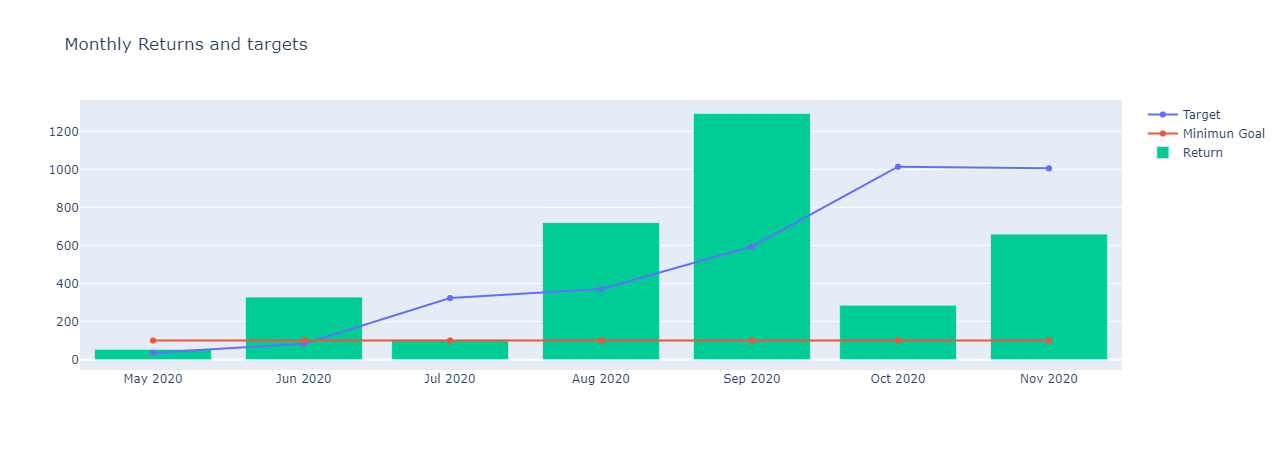

In [25]:
# Monthly Returns and targets
fig = go.Figure(data=[
    go.Scatter(name='Target', x=summary_df['Date'], y=summary_df['Target']),
    go.Scatter(name='Minimun Goal', x=summary_df['Date'], y=[100 for x in range(len(summary_df['Date']))]),
    go.Bar(name='Return', x=monthly_returns_df['Date'], y=monthly_returns_df['Returns']),
])

# Change the bar mode
fig.update_layout(barmode='overlay', title='Monthly Returns and targets')
py.offline.iplot(fig)

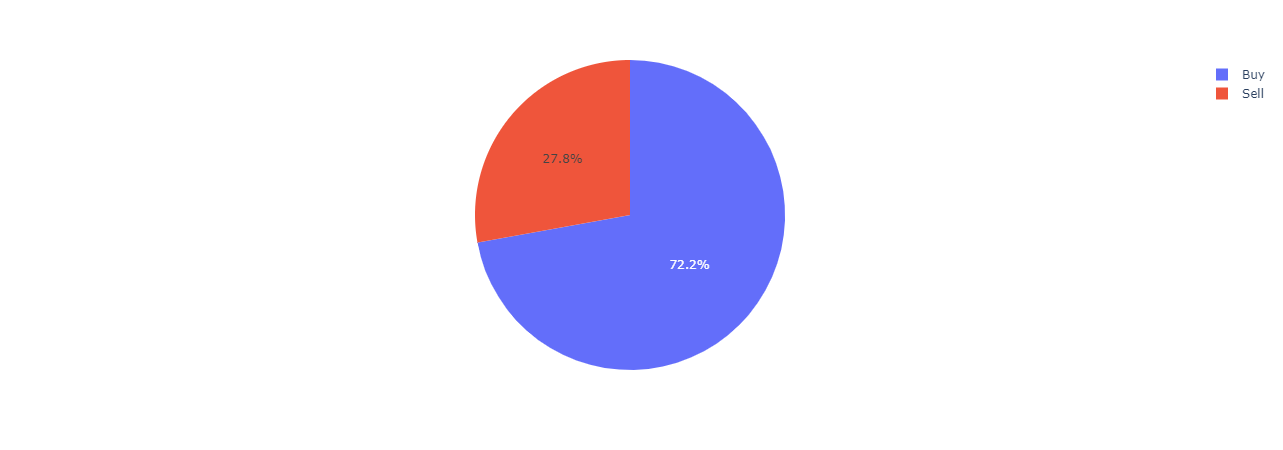

In [26]:
# Buy/Sell
counts = portfolio['Type'].value_counts()       
counts_df = counts.reset_index()
counts_df.columns = ['Type', 'Count']
fig = px.pie(counts_df, values='Count', names='Type')
py.offline.iplot(fig)

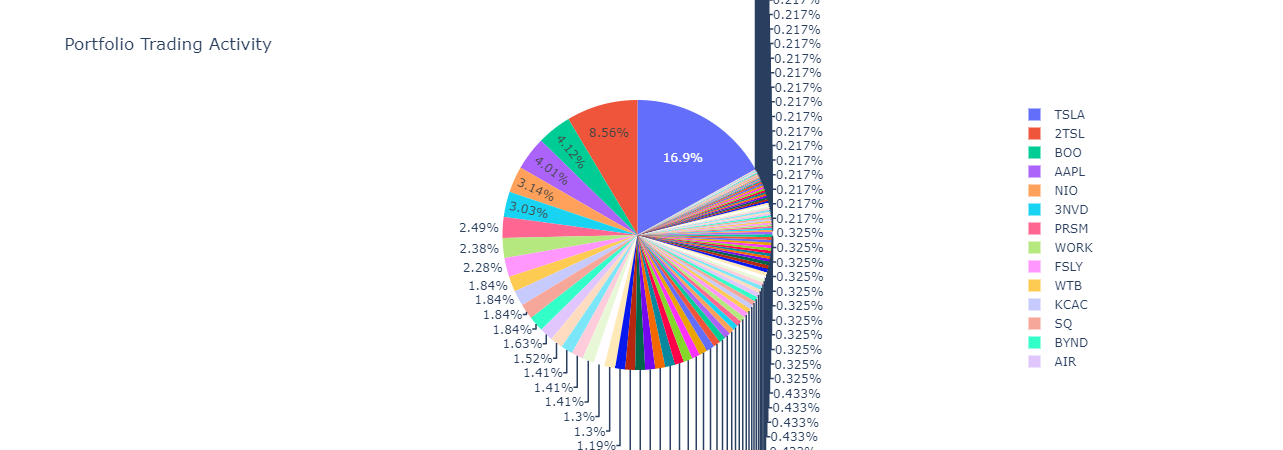

In [27]:
## Stock activity - How many times I've bought/sold a stock         
stocks = portfolio['Ticker Symbol'].value_counts()         
stocks = stocks.reset_index()
stocks.columns = ['Ticker Symbol', 'Count']           
fig = px.pie(stocks, values='Count', names='Ticker Symbol', title='Portfolio Trading Activity')
py.offline.iplot(fig)

In [28]:
## Adjust row for stock splits
def stock_split_adjustment(r):
        
    market = get_market(r['ISIN'], r['Ticker Symbol'])[1] 
    
    ticker = get_yf_symbol(market, r['Ticker Symbol'])
    
    aapl = yf.Ticker(ticker)
    split_df = aapl.splits.reset_index()
    split = split_df[split_df['Date'] > r['Trading day']]['Stock Splits'].sum()
    
    if split > 0:
        r.dolla = r.dolla/split
    
    return r

In [29]:
def get_buy_sell(ticker):
                    
    df = portfolio[portfolio['Ticker Symbol'] == ticker]
    
    df['dolla'] = df['Price'] / df['Exchange rate']
    df['Trading day'] = pd.to_datetime(df['Trading day']) # Match index date format
    
    buys = df[df['Type']=='Buy']
    sells = df[df['Type']=='Sell']
    
    buys = buys.apply(stock_split_adjustment, axis=1)
    sells = sells.apply(stock_split_adjustment, axis=1)
    
    return buys, sells

In [30]:
def chart(ticker):

    market = all_212_equities[all_212_equities['INSTRUMENT'] == ticker]['MARKET NAME'].values[0] 
    
    buys, sells = get_buy_sell(ticker)
    
    start = datetime(2020, 2, 7)
    end = datetime.now()    
        
    yf_symbol = get_yf_symbol(market, ticker)   
    
    index = web.DataReader(yf_symbol, 'yahoo', start, end)
    index = index.reset_index()
    
    ## Candlestick Graph
    fig = go.Figure(data=[go.Candlestick(x=index['Date'],
                    open=index['Open'],
                    high=index['High'],
                    low=index['Low'],
                    close=index['Adj Close'],
                    name='Stock')])
    
    # Buys
    fig.add_trace(go.Scatter(x=sells['Trading day'], y=sells['dolla'],
                        mode='markers',
                        name='Sell point',
                        #marker=dict(color='#ff7f0e')
                        marker=dict(size=7,
                                    line=dict(width=2,
                                              color='DarkSlateGrey')),
                        ))
    
    # Sells
    fig.add_trace(go.Scatter(x=buys['Trading day'], y=buys['dolla'],
                        mode='markers',
                        name='Buy point',
                        #marker=dict(color='#1f77b4')
                        marker=dict(size=7,
                                    line=dict(width=2,
                                              color='DarkSlateGrey')),
                        ))
    
    fig.update_layout(hovermode="x unified", title=f'{ticker} Buy/Sell points') # Currently plotly doesn't support hover for overlapping points in same trace
    
    py.offline.iplot(fig)

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



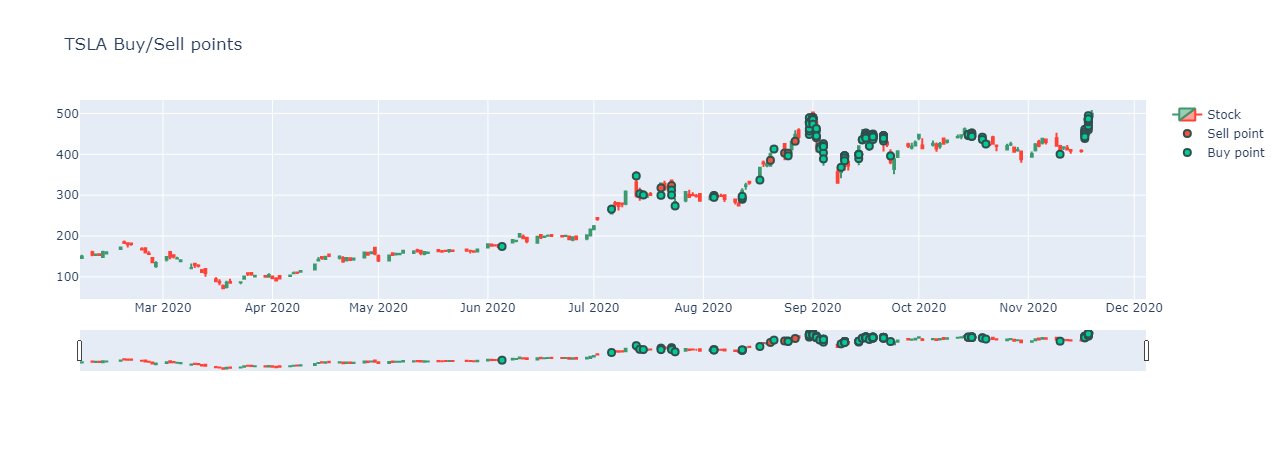

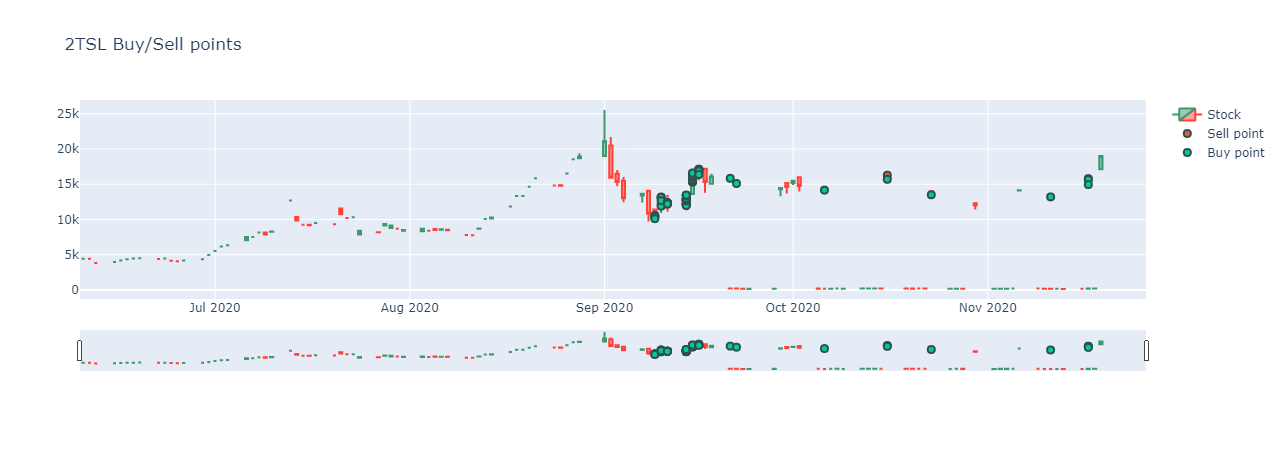

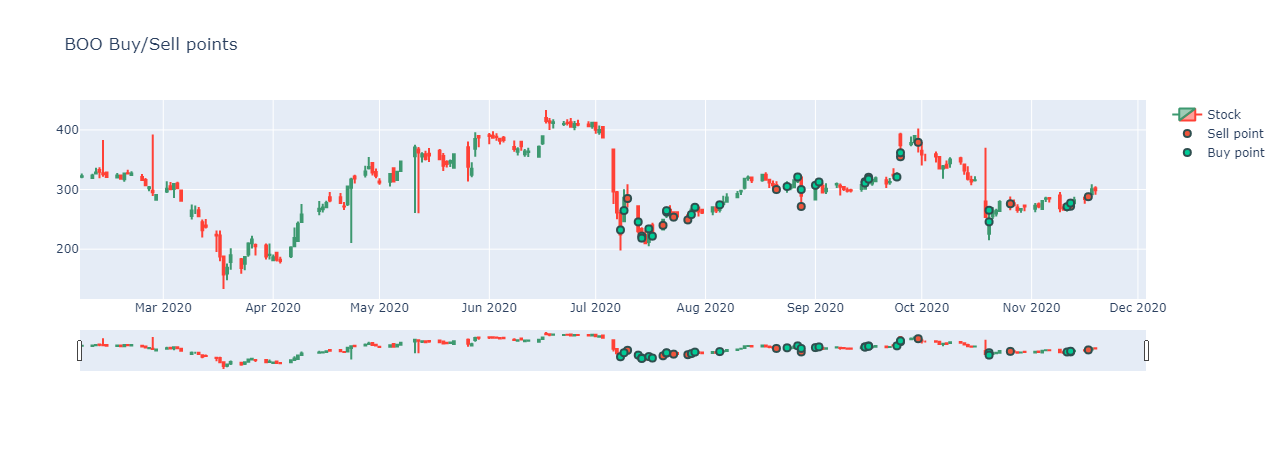

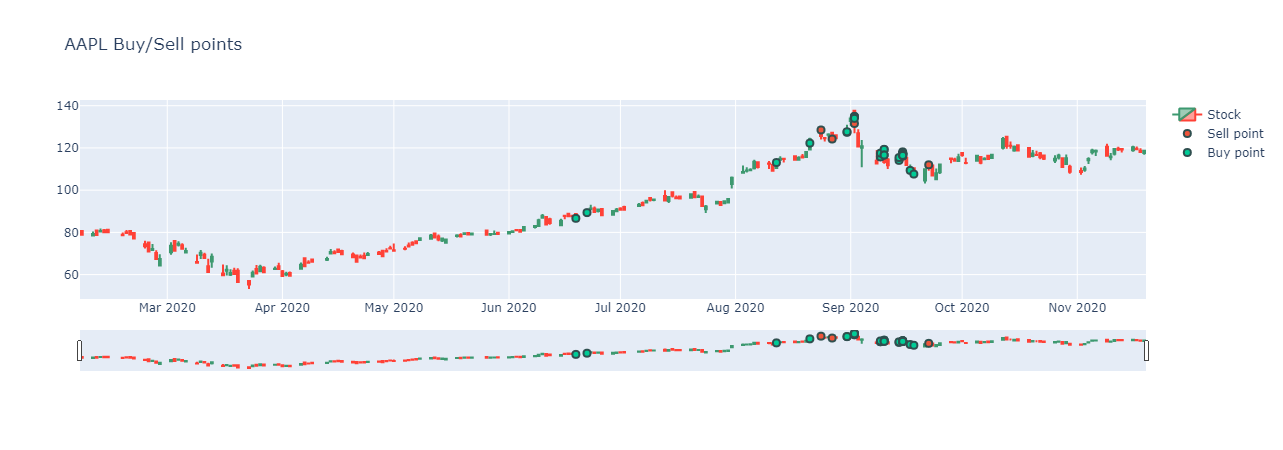

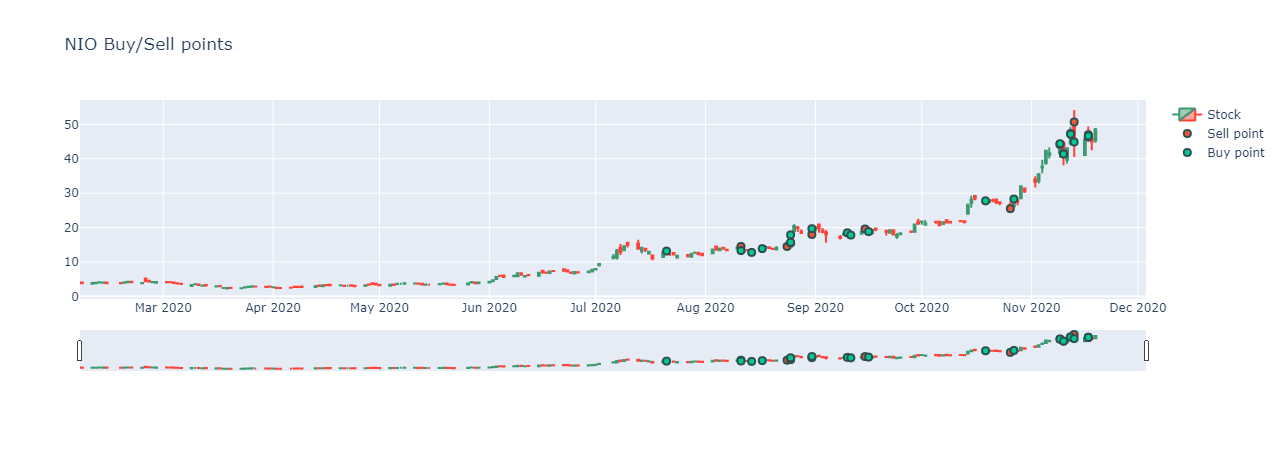

In [31]:
## My Top 5 most traded stocks
top_stocks = portfolio['Ticker Symbol'].value_counts().head()

for stock in top_stocks.index:
    chart(stock)

### Scoring my market timing performance

As you can see from the chart above for the most part I am ok at timing the market however there are some point that I am way off.
For example on July 13th I bought near the high of that day.
To calculate my ability to time the market effectively I'll be calulating the median of the day. If I sold the stock in the top 50% this would be a sucessful trade, whereas if I sold in the bottom half this would be an inefficient/unsuccessful trade. This is vice versa for buy points

This value will act as a baseline for my timing performance.

In [32]:
def performance_chart(ticker):

    market = all_212_equities[all_212_equities['INSTRUMENT'] == ticker]['MARKET NAME'].values[0] 
    
    buys, sells = get_buy_sell(ticker) 
    
    start = datetime(2020, 2, 7)
    end = datetime.now()    
    
    yf_symbol = get_yf_symbol(market, ticker)   
    
    index = web.DataReader(yf_symbol, 'yahoo', start, end)
    index = index.reset_index()
    
    index['Midpoint'] = (index['High'] + index['Low']) / 2
    
    buy_target = []
    sell_target = []
    
    for i, row in buys.iterrows():
        mid = index[index['Date'] == row['Trading day']]['Midpoint'].values[0]
        
        if row['dolla'] < mid:
            buy_target.append(1)
        else:
            buy_target.append(0)
    
    for i, row in sells.iterrows():
        mid = index[index['Date'] == row['Trading day']]['Midpoint'].values[0]
        
        if row['dolla'] > mid:
            sell_target.append(1)
        else:
            sell_target.append(0)
    
    buys['Target'] = buy_target
    sells['Target'] = sell_target
    
    # buy['Target'] = buys.loc[buys['dolla'] < index[index['Date'] == buys['Trading day']]['Midpoint'].values[0], 'test'] = 1
    
    ## Continous colour graph https://plotly.com/python/discrete-color/
    
    fig = go.Figure(data=[go.Candlestick(x=index['Date'],
                    open=index['Open'],
                    high=index['High'],
                    low=index['Low'],
                    close=index['Adj Close'],
                    name='Stock')])
    
    fig1 = px.scatter(sells, x='Trading day', y='dolla', color='Target')
    fig1.update_traces(marker=dict(size=7, line=dict(width=2, color='DarkSlateGrey')))
    fig.add_trace(fig1.data[0])
    
    fig2 = px.scatter(buys, x='Trading day', y='dolla', color='Target')
    fig2.update_traces( marker=dict(size=7, line=dict(width=2, color='DarkSlateGrey')))
    fig.add_trace(fig2.data[0])
    
    fig.update_layout(hovermode="x unified", title=f'{ticker} Stock Graph')
    
    #fig.update_layout(coloraxis_showscale=False)
    
    py.offline.iplot(fig)
    
    ## Discrete color graph
    
    fig = go.Figure(data=[go.Candlestick(x=index['Date'],
                    open=index['Open'],
                    high=index['High'],
                    low=index['Low'],
                    close=index['Adj Close'],
                    name='Stock')])
    
    # Must be a string for plotly to interpret numeric values as a discrete value
    # https://plotly.com/python/discrete-color/
    sells['Target'] = sells['Target'].astype(str)
    buys['Target'] = buys['Target'].astype(str)
    
    fig1 = px.scatter(sells, x='Trading day', y='dolla', color='Target')
    fig1.data[0].marker =  {'color':'#E24C4F', 'line': {'color': 'white', 'width': 2}, 'size': 7, 'symbol': 'circle'}
    fig1.data[1].marker =  {'color':'#E24C4F', 'line': {'color': 'black', 'width': 2}, 'size': 7, 'symbol': 'circle'}
    fig1.data[0].name = 'Successful Sell Point'
    fig1.data[1].name = 'Unsuccessful Sell Point'
    fig.add_trace(fig1.data[0])
    fig.add_trace(fig1.data[1])
    
    fig2 = px.scatter(buys, x='Trading day', y='dolla', color='Target')
    #fig2.update_traces(marker=dict(color='blue'))
    #fig2.update_traces(marker=dict(color='#30C296', size=7, line=dict(width=2, color='DarkSlateGrey')))
    fig2.data[0].marker =  {'color':'#3D9970', 'line': {'color': 'white', 'width': 2}, 'size': 7, 'symbol': 'circle'}
    fig2.data[1].marker =  {'color':'#3D9970','line': {'color': 'black', 'width': 2}, 'size': 7, 'symbol': 'circle'}
    fig2.data[0].name = 'Successful Buy Point'
    fig2.data[1].name = 'Unsuccessful Buy Point'
    fig.add_trace(fig2.data[0])
    fig.add_trace(fig2.data[1])
    
    # fig.add_trace(go.Scatter(x=sells['Trading day'], y=sells['dolla'],
    #                     mode='markers',
    #                     name='Sell point',
    #                     color='Target' 
    #                     ))
    
    # fig.add_trace(go.Scatter(x=buys['Trading day'], y=buys['dolla'],
    #                     mode='markers',
    #                     name='Buy point',
    #                     marker=dict(color='Target')
    #                     ))
    
    fig.update_layout(hovermode="x unified", title=f'{ticker} Stock Graph')
    
    py.offline.iplot(fig)

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



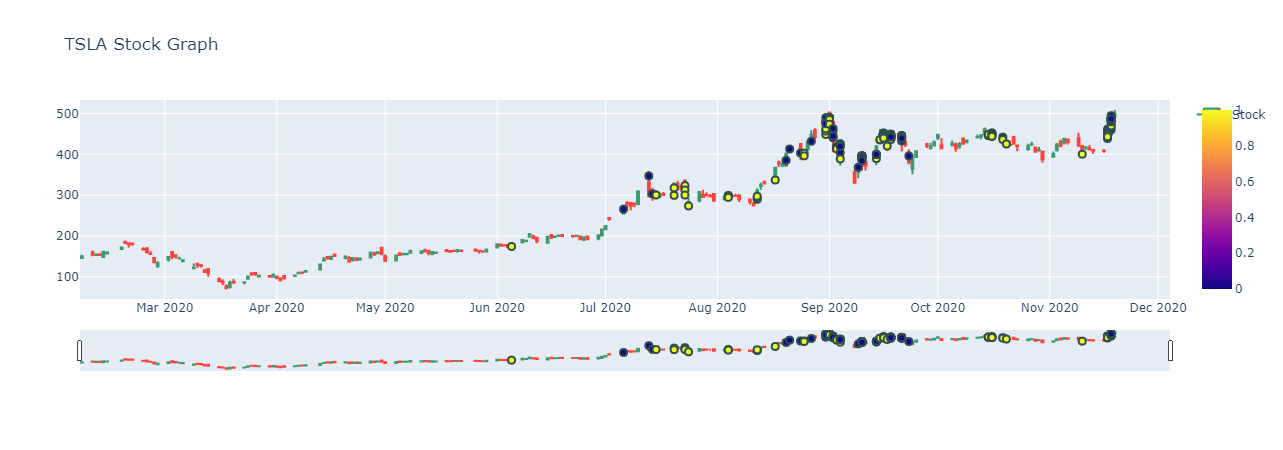

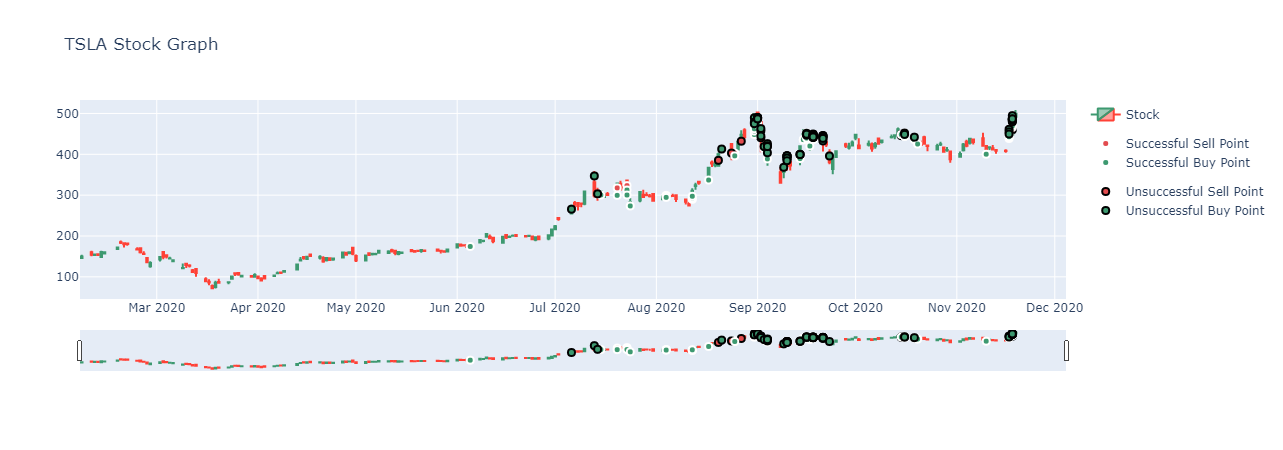

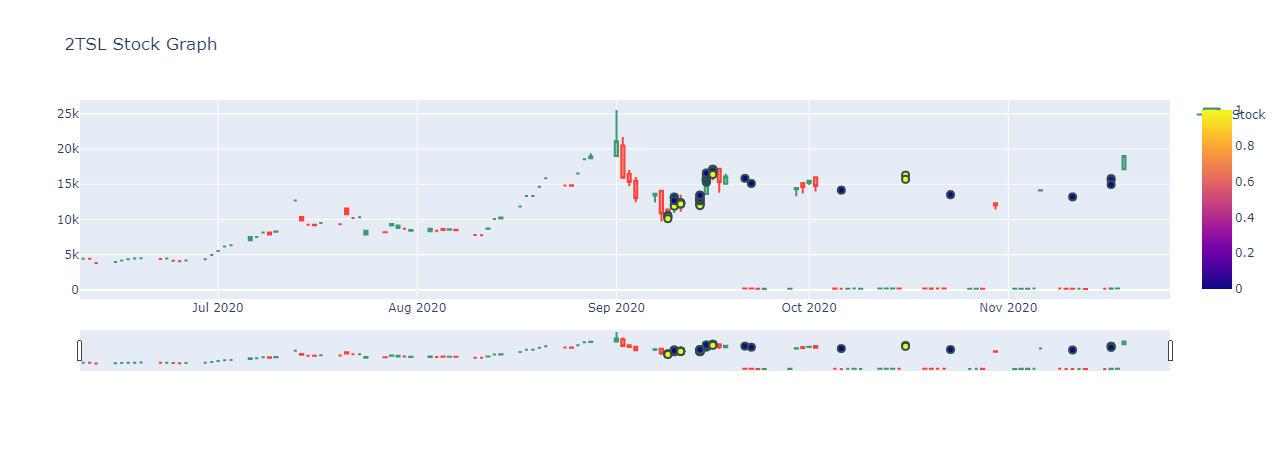

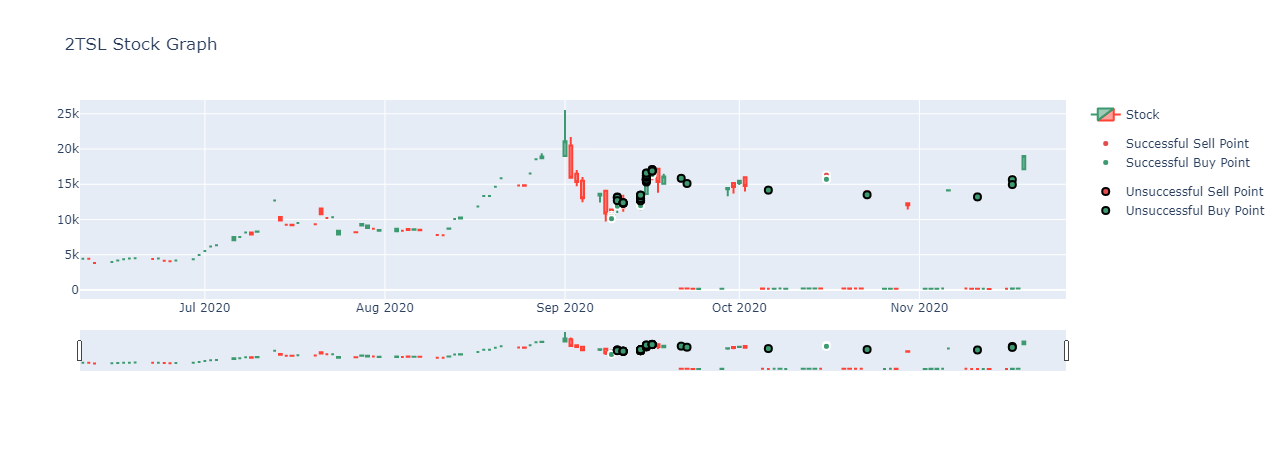

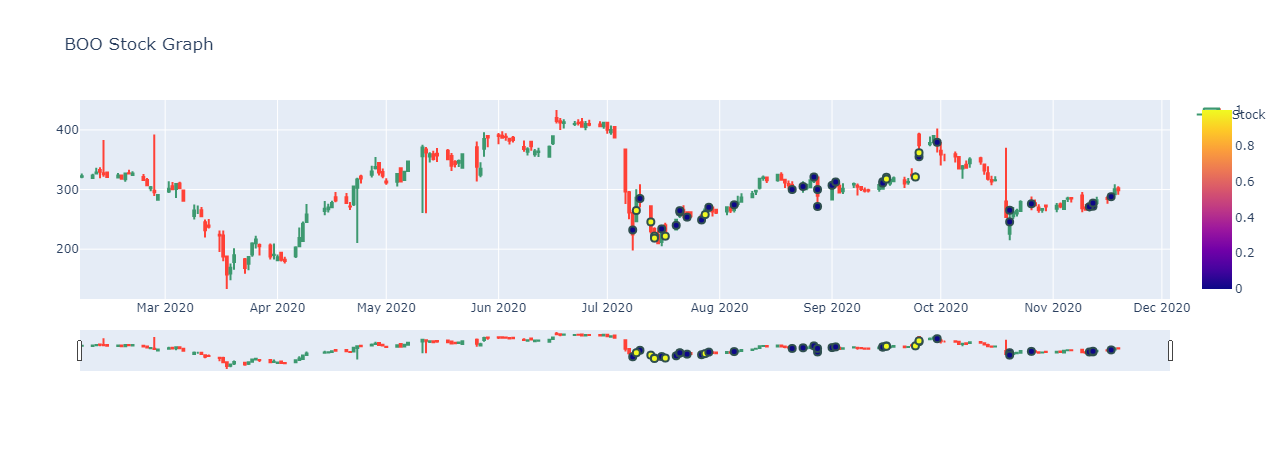

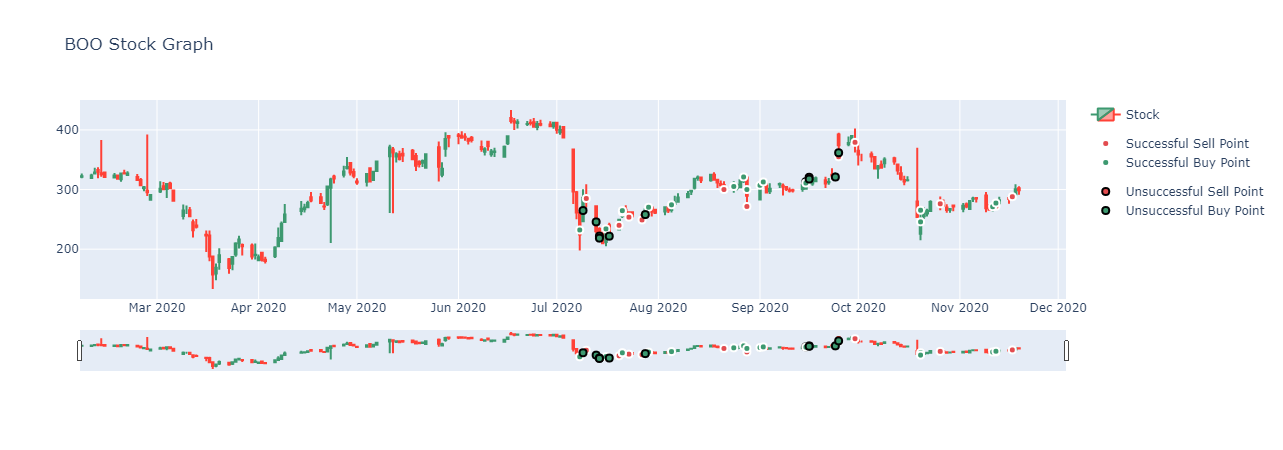

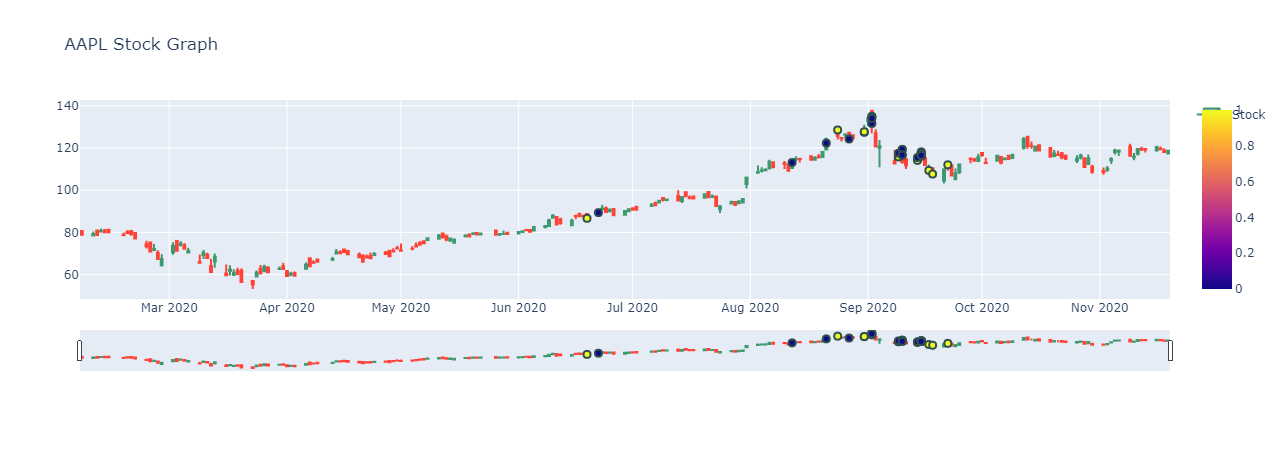

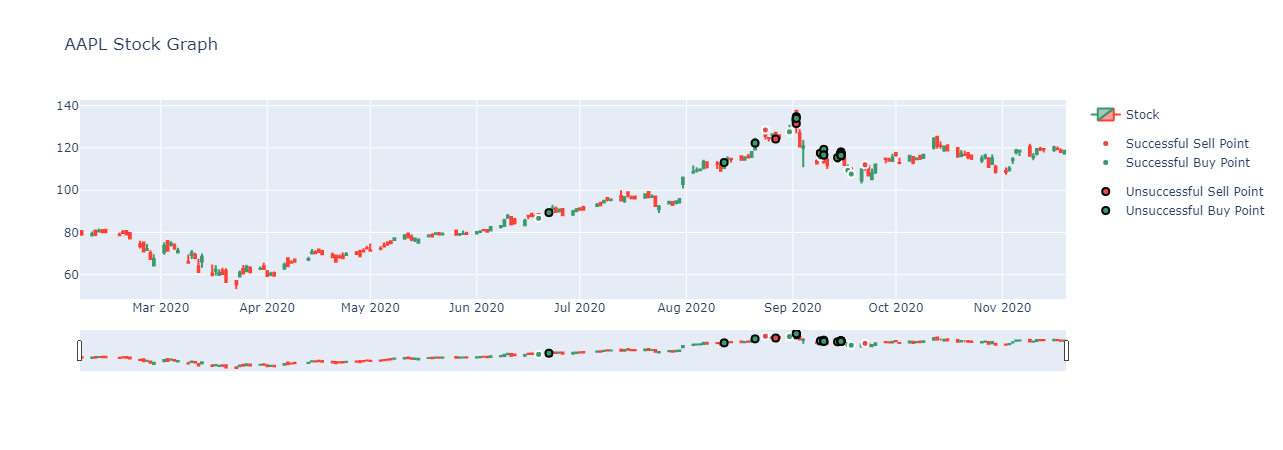

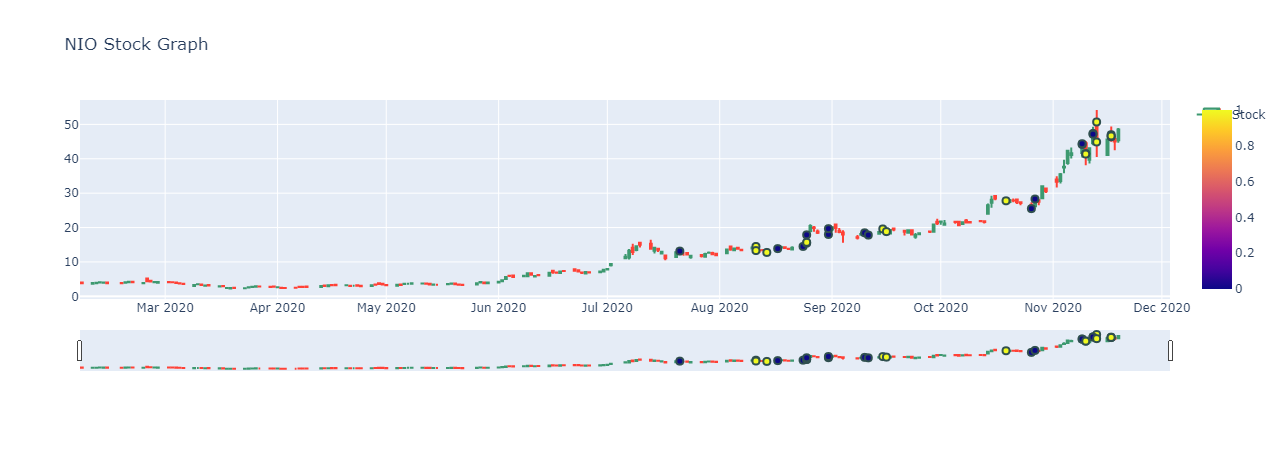

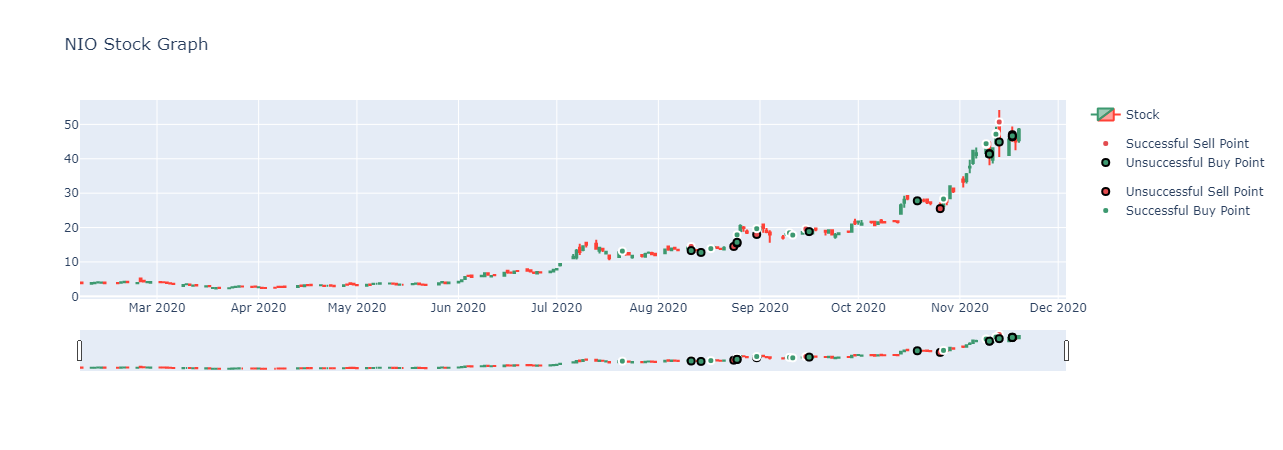

In [33]:
for stock in top_stocks.index:
    performance_chart(stock)

### Will be focusing on Tesla as that is my most traded stock

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



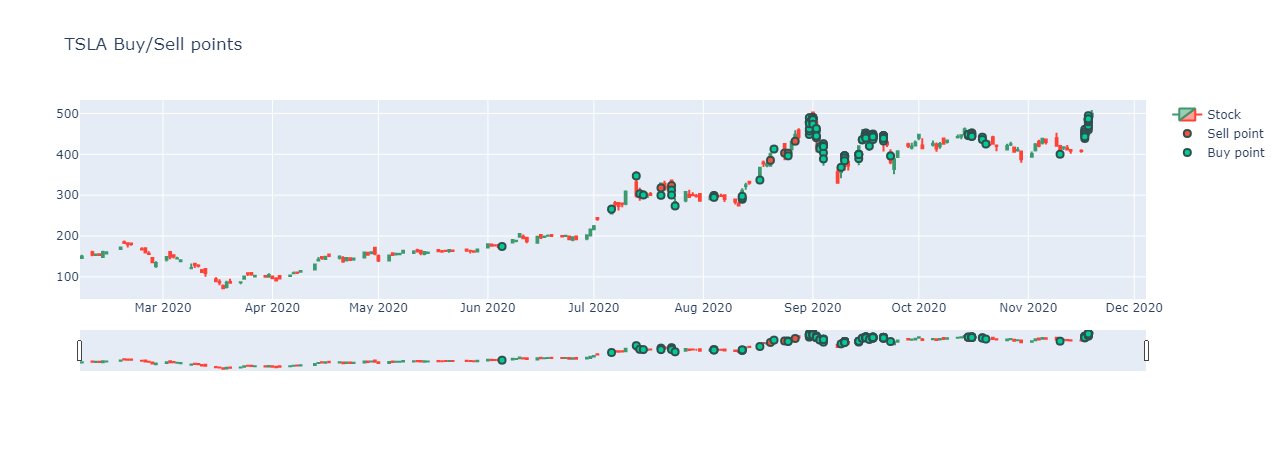

In [34]:
chart('TSLA')

The dip in the price in March corresponds to the COVID-19 pandemic and the financial crisis that it brought with it.

There was a considerable uptick in the price in August due to the announcement of a 5-1 stock split. This is a clear example of investor sentiment beating logic. A stock split does not increase the value of a stock, but on this news, stocks rose nearly 100%. Examples like these are why I think user activity and the sentiment is an important indicator of a stock price.

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



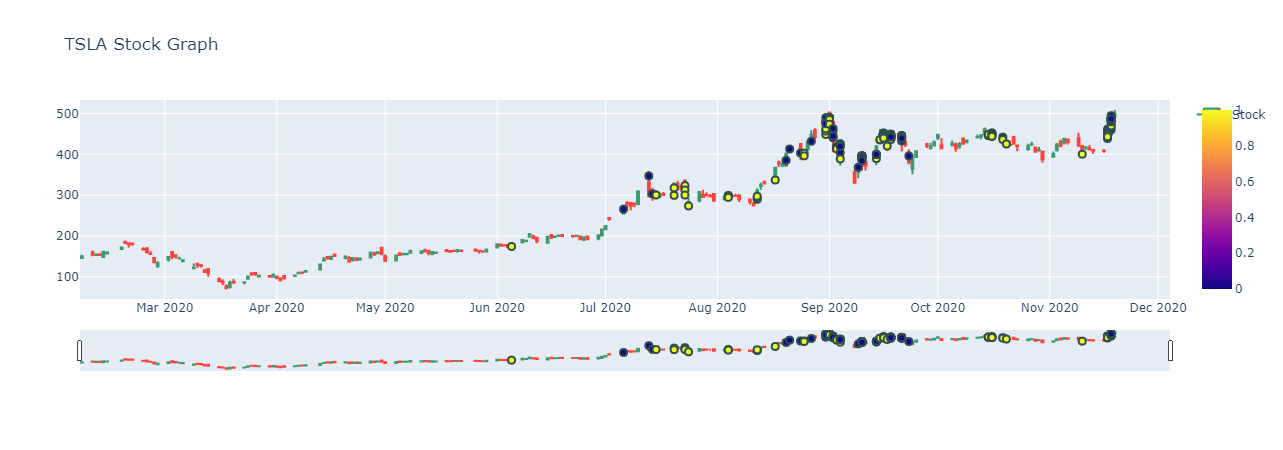

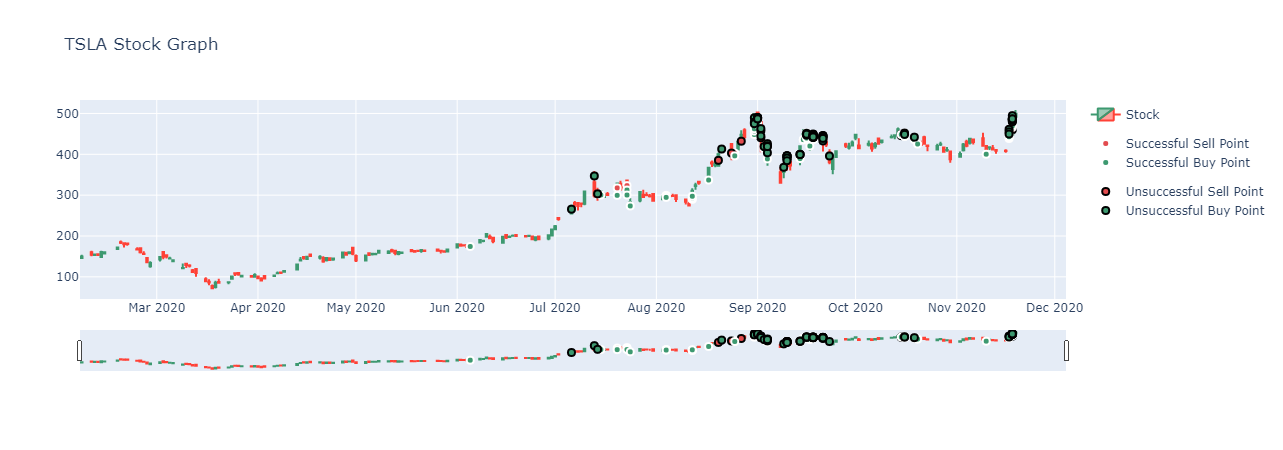

In [35]:
performance_chart('TSLA')

In [36]:
index = web.DataReader('TSLA', 'yahoo', start, end)
index = index.reset_index()

index['Midpoint'] = (index['High'] + index['Low']) / 2

buys, sells = get_buy_sell('TSLA')

buy_target = []
sell_target = []

for i, row in buys.iterrows():
    mid = index[index['Date'] == row['Trading day']]['Midpoint'].values[0]

    if row['dolla'] < mid:
        buy_target.append(1)
    else:
        buy_target.append(0)

for i, row in sells.iterrows():
    mid = index[index['Date'] == row['Trading day']]['Midpoint'].values[0]

    if row['dolla'] > mid:
        sell_target.append(1)
    else:
        sell_target.append(0)

buys['Target'] = buy_target
sells['Target'] = sell_target
count = buys['Target'].value_counts().add(sells['Target'].value_counts(),fill_value=0)

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\david\Anaconda3\envs\digital_dashboard\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [37]:
percentage = count[1]/count.sum() *100
percentage = '{:.2f}'.format(percentage)
print(f'Successful trades {percentage}%')

Successful trades 46.15%


My performance was just under 50% which is pretty bad in my opinion. Especially with a generous margin of 50%

### Scraping user data

https://www.trading212.com/en/hotlist

On 2nd November Trading 212 added a popularity tracker to their site. Trading 212 uses javascript to load the data so have to use Selenium instead of the beautifulsoup used for the stock list and my portfolio. T212 doesn't store historical data so will be scrapping site daily and storing the results in a csv.

In [38]:
import pandas as pd
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
#from selenium.common.exceptions import NoSuchElementException
from fake_useragent import UserAgent
import time
from datetime import date, datetime
from webdriver_manager.chrome import ChromeDriverManager
import re

In [39]:
timestamp = date.today().strftime('%d-%m-%Y')

## Using Long table as it's more flexible for this dataset
## Improve: use database instead of csv
leaderboard = pd.read_csv('leaderboard.csv', parse_dates=['Date', 'Last_updated'], dayfirst=True) # Date format changes for some observations when reading csv unsure why
risers = pd.read_csv('risers.csv', parse_dates=['Date', 'Last_updated'], dayfirst=True)
fallers = pd.read_csv('fallers.csv', parse_dates=['Date', 'Last_updated'], dayfirst=True)

columns = ['Stock', 'Position', 'Start', 'End', 'Date', 'User_change', 'Percentage_change', 'Last_updated']

## Selenium Setup

In [40]:
def get_driver():
    options = Options()
    ua = UserAgent()
    userAgent = ua.random
    options.add_argument(f'user-agent={userAgent}')
    
    ## Headless browser - doesn't pop up
    ## A headless browser is a web browser without a graphical user interface.
    #options.add_argument("--headless")  
    
    return webdriver.Chrome(ChromeDriverManager().install(), options=options) # automatically use the correct chromedriver by using the webdrive-manager
    #return webdriver.Chrome('./chromedriver', options=options)

driver = get_driver()

[WDM] - Current google-chrome version is 86.0.4240
[WDM] - Get LATEST driver version for 86.0.4240


[WDM] - Driver [C:\Users\david\.wdm\drivers\chromedriver\win32\86.0.4240.22\chromedriver.exe] found in cache


## Getting leaderboard data

In [41]:
daily_hotlist = []

driver.get(f'https://www.trading212.com/en/hotlist')

time.sleep(5) # Pause for page to load

elements = driver.find_elements_by_class_name("pt-popularity-content-item")

def get_last_update(update):
    match = re.search(r'\d{2}/\d{2}/\d{4}, \d{2}:\d{2}:\d{2}', update)
    last_update = datetime.strptime(match.group(), '%d/%m/%Y, %H:%M:%S').strftime('%d-%m-%Y %H:%M:%S')
    return last_update

# Get date from string
update = driver.find_element_by_class_name("pt-footer-notice").text
last_update = get_last_update(update)

for stock in elements:
    daily_hotlist.append([stock.find_element_by_class_name('pt-name').text, 
            stock.find_element_by_class_name('pt-number').text, 
            stock.find_element_by_class_name('pt-holders-count').text, 
            timestamp,
            last_update])

## Direct correlation between position and user count so should remove position for model
data = pd.DataFrame(daily_hotlist, columns=['Stock', 'Position', 'User_count', 'Date', 'Last_updated'])
data['User_count'] = data['User_count'].str.replace(',', '').astype(float)

data[['Date','Last_updated']] = data[['Date','Last_updated']].apply(pd.to_datetime)

df = pd.concat([data, leaderboard], ignore_index=True)

## This script will run several times a day to get as much data as possible. 
## Because positions throughout the day will keep changing. For example when US or UK markets open stocks in their
## region would naturally climb up the table.

complete_df = df.sort_values('User_count', ascending=False).drop_duplicates(['Stock','Date'], keep='first').reset_index(drop=True) #.sort_index()

## Fixing positions column
#complete_df['Last_updated'] = pd.to_datetime(complete_df.Last_updated)
complete_df['Date'] = pd.to_datetime(complete_df.Date)
complete_df = complete_df.sort_values(['Date', 'User_count'], ascending=[True, False])

comp = pd.DataFrame()

for d in complete_df['Date'].unique():
    temp_df = complete_df[complete_df['Date'] == d].reset_index(drop=True)
    temp_df['Position'] = list(temp_df.index+1)
    comp = comp.append(temp_df, ignore_index=True)

complete_df = comp.copy()
complete_df['Date'] = complete_df['Date'].dt.strftime('%d/%m/%Y')
complete_df.to_csv('leaderboard.csv', index=False)

In [42]:
complete_df.head()

,Stock,Position,User_count,Date,Last_updated
0,Tesla,1,96518.0,11/11/2020,2020-11-11 18:10:00
1,Apple,2,81421.0,11/11/2020,2020-11-11 18:00:00
2,Amazon,3,69608.0,11/11/2020,2020-11-11 20:00:00
3,NIO Inc,4,50294.0,11/11/2020,2020-11-11 20:00:00
4,BP PLC,5,43664.0,11/11/2020,2020-11-11 18:00:00


In [43]:
complete_df['User_count'].describe()

count      694.000000
mean     17902.053314
std      15606.865129
min       5844.000000
25%       7711.000000
50%      12034.500000
75%      22998.250000
max      98630.000000
Name: User_count, dtype: float64

## Daily Risers/Fallers

In [44]:
def user_data(xpath, file, historical_df):
    daily = []
    
    driver.find_element_by_xpath(xpath).click()
    
    time.sleep(5) # Pause for page to load
    
    update = driver.find_element_by_class_name("pt-footer-notice").text
    last_update = get_last_update(update)
    
    elements = driver.find_elements_by_class_name("pt-popularity-content-item")
    
    for stock in elements[1:]:
        daily.append([stock.find_element_by_class_name('pt-name').text, 
                stock.find_element_by_class_name('pt-number').text, 
                stock.find_element_by_class_name('pt-change').text,
                stock.find_element_by_class_name('pt-start').text,
                stock.find_element_by_class_name('pt-end').text,
                timestamp,
                last_update])
    
    data = pd.DataFrame(daily, columns=['Stock', 'Position', 'Change','Start', 'End', 'Date', 'Last_updated'])
    
    data[['User_change','Percentage_change']] = data['Change'].str.split(' ', expand=True)
    data = data.drop('Change', 1) # inplace=True not working
    data['Percentage_change'] = data['Percentage_change'].str.strip('()').str.strip('%').astype(float) # Remove brackets
    data['User_change'] = data['User_change'].str.replace(',', '').astype(float)
    data['Start'] = data['Start'].str.replace(',', '').astype(float)
    data['End'] = data['End'].str.replace(',', '').astype(float)
    data[['Date','Last_updated']] = data[['Date','Last_updated']].apply(pd.to_datetime)
    
    data = data[columns]
    
    df = pd.concat([data, historical_df], ignore_index=True)
    
    ## To fix fallers position column make column abs then times by -1 after reorder
    
    complete_df = df.sort_values('User_change', ascending=False).drop_duplicates(['Stock','Date'], keep='first').reset_index(drop=True)
    
    complete_df['User_change'] = complete_df['User_change'].abs()
    
    #complete_df['Date'] = pd.to_datetime(complete_df.Date)
    
    complete_df[['Date','Last_updated']] = complete_df[['Date','Last_updated']].apply(pd.to_datetime)

    complete_df = complete_df.sort_values(['Date', 'User_change'], ascending=[True, False])

    comp = pd.DataFrame()
    
    for d in complete_df['Date'].unique():
        temp_df = complete_df[complete_df['Date'] == d].reset_index(drop=True)
        temp_df['Position'] = list(temp_df.index+1)
        comp = comp.append(temp_df, ignore_index=True)
    
    complete_df = comp.copy()
    
    #complete_df['User_change'] = complete_df['User_change'] * -1
    complete_df['Date'] = complete_df['Date'].dt.strftime('%d/%m/%Y')
    complete_df.to_csv(file, index=False)
    
    return complete_df

In [45]:
risers_df = user_data("/html/body/div[1]/section[2]/div/div/div[1]/div/div[2]", 'risers.csv', risers)

In [46]:
risers_df.head()

,Stock,Position,Start,End,Date,User_change,Percentage_change,Last_updated
0,Rolls-Royce Holdings,1,33420.0,34729.0,11/11/2020,1309.0,3.92,2020-11-11 18:00:00
1,Alibaba,2,25649.0,26835.0,11/11/2020,1186.0,4.62,2020-11-11 19:30:00
2,Amazon,3,68541.0,69622.0,11/11/2020,1081.0,1.58,2020-11-11 20:00:00
3,Pfizer,4,32263.0,33022.0,11/11/2020,759.0,2.35,2020-11-11 20:00:00
4,NIO Inc,5,49641.0,50345.0,11/11/2020,704.0,1.42,2020-11-11 20:00:00


In [47]:
fallers_df = user_data("/html/body/div[1]/section[2]/div/div/div[1]/div/div[3]", 'fallers.csv', fallers)

In [48]:
fallers_df.head()

,Stock,Position,Start,End,Date,User_change,Percentage_change,Last_updated
0,National Grid,1,37990.0,37768.0,11/11/2020,222.0,0.58,2020-11-11 18:00:00
1,Greenland Technologies,2,947.0,749.0,11/11/2020,198.0,20.91,2020-11-11 18:00:00
2,CBL & Associates,3,1387.0,1240.0,11/11/2020,147.0,10.60,2020-11-11 20:00:00
3,GraniteShares 3x Short NVIDIA,4,309.0,198.0,11/11/2020,111.0,35.92,2020-11-11 18:00:00
4,Vaccinex,5,230.0,129.0,11/11/2020,101.0,43.91,2020-11-11 19:30:00


## Selenium Shutdown

In [49]:
driver.close()
driver.quit()

## TODO:

* Find out events that led to spikes and dips in stock price
* Scrap google search volume
* Find or create sentiment analysis model for news on stock
* Make sure implement feature scaling as range for columns are different. Price in 00s volumn in 000s, as they're not in same scale this will lead to issues in the machine learning models and that is because due to the very nature of many different machine learning models a lot of machine knowledge models are generally based on some form of distance measure such as Euclidean distance. models will think the smaller number is negligable and ignore it. Putting columns on the same scale avoids this.
